<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Homework9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [ ]:
### CODE FROM CLASSES (loading data and preparing network)

import torch
import torchvision
import matplotlib.pyplot as plt


# reading MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

# mean and std of dataset
mean_dataset = trainset.data.numpy().mean()/255.0
std_dataset = trainset.data.numpy().std()/255.0

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((mean_dataset), (std_dataset))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

        # Define all layers explicitly
        self.linear1 = torch.nn.Linear(1*28*28, 1024)  # First linear layer
        self.linear2 = torch.nn.Linear(1024, 2048)     # Second linear layer
        self.linear3 = torch.nn.Linear(2048, 256)      # Third linear layer
        self.linear4 = torch.nn.Linear(256, 10)        # Final linear layer (no activation)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # Input shape: (B, 1, 28, 28)
        x = self.flatten(x)    # Shape: (B, 784)

        # Pass through all layers with ReLU activation
        x = self.relu(self.linear1(x))  # Shape: (B, 1024)
        x = self.relu(self.linear2(x))  # Shape: (B, 2048)
        x = self.relu(self.linear3(x))  # Shape: (B, 256)
        x = self.linear4(x)             # Shape: (B, 10) - no activation

        x = self.dropout(x)
        return x

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.30MB/s]


In [ ]:
### CODE FROM CLASSES (moving calculations to GPU and training net)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.295391798019409
epoch: 0 batch: 1 current batch loss: 2.056147813796997
epoch: 0 batch: 2 current batch loss: 1.534996747970581
epoch: 0 batch: 3 current batch loss: 1.064370036125183
epoch: 0 batch: 4 current batch loss: 1.3524545431137085
epoch: 0 batch: 5 current batch loss: 1.0740447044372559
epoch: 0 batch: 6 current batch loss: 1.0136826038360596
epoch: 0 batch: 7 current batch loss: 0.6695560216903687
epoch: 0 batch: 8 current batch loss: 0.8047613501548767
epoch: 0 batch: 9 current batch loss: 0.7971583604812622
epoch: 0 batch: 10 current batch loss: 0.6286386847496033
epoch: 0 batch: 11 current batch loss: 0.5598305463790894
epoch: 0 batch: 12 current batch loss: 0.5631125569343567
epoch: 0 batch: 13 current batch loss: 0.582457423210144
epoch: 0 batch: 14 current batch loss: 0.5270708203315735
epoch: 0 batch: 15 current batch loss: 0.4711446464061737
epoch: 0 batch: 16 current batch loss: 0.4448328912258148
epoch: 0 batc

In [ ]:
### CODE FROM CLASSES (checking accuracy of the net)

good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9815


Step 0, Loss: 4.5887, Confidence: [0.005, 0.103, 0.004, 0.038, 0.0, 0.07, 0.005, 0.063, 0.007, 0.002]
Step 50, Loss: 0.0021, Confidence: [0.999, 0.996, 0.998, 0.999, 1.0, 0.999, 0.996, 0.998, 0.997, 0.996]
Step 100, Loss: 0.0014, Confidence: [0.999, 0.998, 0.999, 1.0, 1.0, 1.0, 0.998, 0.999, 0.998, 0.997]
Step 150, Loss: 0.0011, Confidence: [0.999, 0.999, 0.999, 1.0, 1.0, 1.0, 0.998, 0.999, 0.998, 0.998]
Step 200, Loss: 0.0009, Confidence: [1.0, 0.999, 0.999, 1.0, 1.0, 1.0, 0.999, 0.999, 0.999, 0.998]
Step 250, Loss: 0.0007, Confidence: [1.0, 0.999, 0.999, 1.0, 1.0, 1.0, 0.999, 0.999, 0.999, 0.998]
Step 300, Loss: 0.0006, Confidence: [1.0, 0.999, 0.999, 1.0, 1.0, 1.0, 0.999, 0.999, 0.999, 0.999]
Step 350, Loss: 0.0005, Confidence: [1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 0.999, 1.0, 0.999, 0.999]
Step 400, Loss: 0.0005, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 0.999, 0.999]
Step 450, Loss: 0.0004, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 0.999, 0.999]
Step 500, Loss

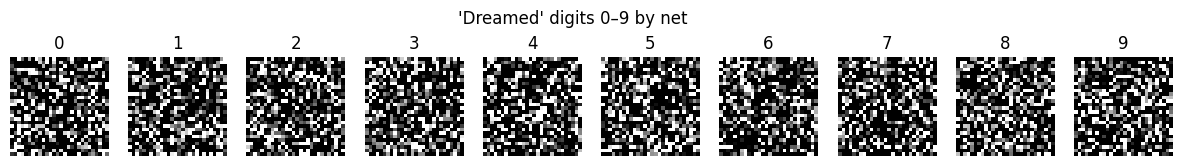

In [ ]:
### PROBLEM 1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# setting up network
net.eval()

# gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# setting target classes for images: i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

# "dreaming" procedure; optimizing random gaussian input images
for step in range(3000):

    # freezing weights of the net
    optimizer.zero_grad()

    # defining loss function and optimizing
    logits = net(dreamed_inputs)
    loss = F.cross_entropy(logits, target_classes)
    loss.backward()
    optimizer.step()

    # displaying values of loss function and probabilities that i-th image is i-th digit
    if step % 50 == 0 or step == 2999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}")

# preparing for vizualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# vizualization of "dreamed" digits by the net
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle("'Dreamed' digits 0–9 by net")
plt.show()


**Problem 1:**

**Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?**

Wygenerowane za pomocą siecie obrazki z cyframi nie przypominają prawdziwych cyfr z zbioru danych MNIST. Dzieje się tak, nawet pomimo faktu, iż sieć z bardzo dużą pewnością przyporządkowuje konkretne obrazki do konkretnych cyfr - widzimy, że dla późniejszych kroków algorytmu "confidence", czyli prawdopodobieństwo wskazane przez algorytm, że dany obraz to konkretna cyfra, wynosi praktycznie 1 dla wszytskich dziesięciu obrazków.

Fakt, że obrazki nie są podobne do rzeczywistych cyfr, wynika z tego, iż opracowana sieć neronowa nie wymaga, aby obrazki wyglądały jak prawdziwe liczby. Dla sieci wystarczy wyłącznie, aby obraz posiadał cechy, dzięki którym sieć nauczyła się rozpoznawać dany obraz jako konkretną cyfrę. Takie cechy mogą być nieintuicyjne i niezrozumiałe dla człowieka. W związku z tym, podczas "śnienia" obrazków sieci premiuje "wzorce" na obrazkach, które są ważne dla sieci z perspektywy określania czy dany obrazek jest konkretną cyfrą, jednak mogą być kompletnie niezrozumiałe dla ludzkiego oka. Ponadto, na tym etapie nie wprowadziliśmy jeszcze żadnej penalizacji szumu i, zatem, obrazy są tworzone tylko z myślą o maksymalizacji prawdopodobieństwa przynależności do danej klasy, przez co obrazki mogą zawierać duży szum, co jescze bardziej utrudnia człowiekowi rozpoznanie cyfry.

Step 0
  Class 3: 0.7211
  Class 8: 0.0011
  Mean Target Prob: 0.3611
Step 100
  Class 3: 0.4901
  Class 8: 0.4814
  Mean Target Prob: 0.4857
Step 200
  Class 3: 0.4899
  Class 8: 0.4898
  Mean Target Prob: 0.4898
Step 300
  Class 3: 0.4919
  Class 8: 0.4919
  Mean Target Prob: 0.4919
Step 400
  Class 3: 0.4933
  Class 8: 0.4933
  Mean Target Prob: 0.4933
Step 500
  Class 3: 0.4942
  Class 8: 0.4942
  Mean Target Prob: 0.4942
Step 600
  Class 3: 0.4949
  Class 8: 0.4949
  Mean Target Prob: 0.4949
Step 700
  Class 3: 0.4955
  Class 8: 0.4955
  Mean Target Prob: 0.4955
Step 800
  Class 3: 0.4959
  Class 8: 0.4959
  Mean Target Prob: 0.4959
Step 900
  Class 3: 0.4962
  Class 8: 0.4962
  Mean Target Prob: 0.4962
Step 1000
  Class 3: 0.4965
  Class 8: 0.4965
  Mean Target Prob: 0.4965
Step 1100
  Class 3: 0.4968
  Class 8: 0.4968
  Mean Target Prob: 0.4968
Step 1200
  Class 3: 0.4970
  Class 8: 0.4970
  Mean Target Prob: 0.4970
Step 1300
  Class 3: 0.4972
  Class 8: 0.4972
  Mean Target Pro

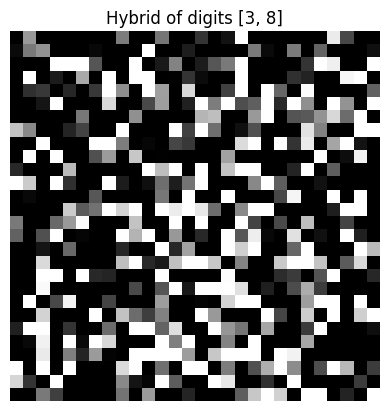

In [ ]:
### PROBLEM 2

# choosing two digits; we will try to construct hybrid of these two digits with our net
target_classes = [3, 8]

# generating one random gaussian noise image
hybrid_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

# setting up optimizer
optimizer = torch.optim.Adam([hybrid_input], lr=0.01)

for step in range(3000):
    # freezing weights
    optimizer.zero_grad()


    logits = net(hybrid_input)
    probs = F.softmax(logits, dim=1)

    # we will want to maximize probability of the image being in class "3" and "8" simultaneously
    target_probs = probs[0, target_classes]

    # probability of digit being 3 and 8
    prob3 = probs[0, target_classes[0]]
    prob8 = probs[0, target_classes[1]]

    # defining loss function in such a way that it should converge to situation that: probability of class "3" ≈ 0.5 and probability of class "8" ≈ 0.5
    loss = (prob3 - 0.5) ** 2 + (prob8 - 0.5) ** 2

    # optimizing
    loss.backward()
    optimizer.step()

    # displaying values of loss function and probabilities of class "3" and "8"
    if step % 100 == 0 or step == 2999:
        print(f"Step {step}\n"
          f"  Class {target_classes[0]}: {target_probs[0].item():.4f}\n"
          f"  Class {target_classes[1]}: {target_probs[1].item():.4f}\n"
          f"  Mean Target Prob: {target_probs.mean().item():.4f}")

# preparing for vizualization
hybrid_image_vis = hybrid_input.detach().cpu().clone()
hybrid_image_vis = hybrid_image_vis.clamp(0, 1)

#vizualization
plt.imshow(hybrid_image_vis[0, 0], cmap='gray')
plt.axis('off')
plt.title(f"Hybrid of digits {target_classes}")
plt.show()


**Problem 2:**

W powyższym algorytmie podjęto się wygenerowania obrazka, który przyppomina 2 cyfy jednocześnie (u nas miał przypominać cyfry 3 i 8). Aby to osiągnąć, psotępowano podobnie jak dla Problemu 1: wygenerowano jeden obrazek będący szumem losowym, aby później go "zoptymalizować". Jednak, wprowadzono nową funckję straty: $loss = (prob3 - 0.5) ^ 2 + (prob8 - 0.5) ^ 2$. Przyjęto taką funkcję staty, gdyż chciano dążyć do sytuacji, gdzie algorytm wygeneruje obrazek, dla którego prawdopodobieństwo, że obrazek reprezentuje cyfrę "3" i prawdopodobieństwo, że obrazek reprezentuje cyfrę "8" będą wynosiły około 0.5. Jak możemy zobaczyć w *outpucie* powyższego algorytmu, faktycznie algorytm prowadzi do sytuacji, gdzie oba te prawdopodobieństwa wynoszą około 0.5.

Gdybyśmy chcieli stowrzyć algorytm generujący obrazek podobny do trzech lub więcej cyfr, możnaby postąpić analogicznie, tzn. dla n cyfr dążylibyśmy do sytuacji, gdzie prawdopodobieństwo, iż obrazek to dana cyfra to 1/n.

W tym przypadku, tak jak w Problemie 1, obrazek również nie za bardzo przypomina rzeczywiste liczby (z tych samych powodów jak w Problemie 1). Jednak, da się zauważyć (według mnie) pewne wzorce na tym obrazku, które przypominają cyfry "3" i "8". Poniżej wstawiam, gdzie widzę wzorce cyfry "3" i "8", jednak może być to trochę naciągane (więc może lepiej to traktować jako "ciekawostkę").

Tutaj można "dopatrzyć się" cyfry "3":


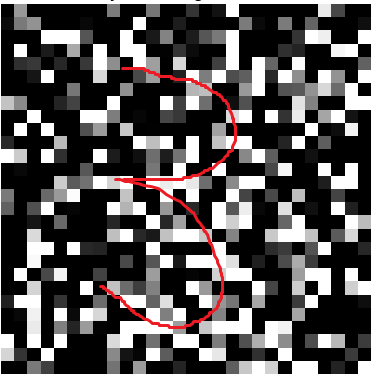



A tutaj cyfry "8":


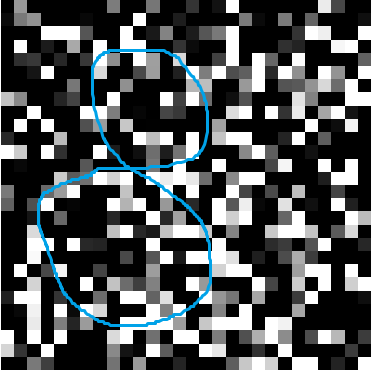

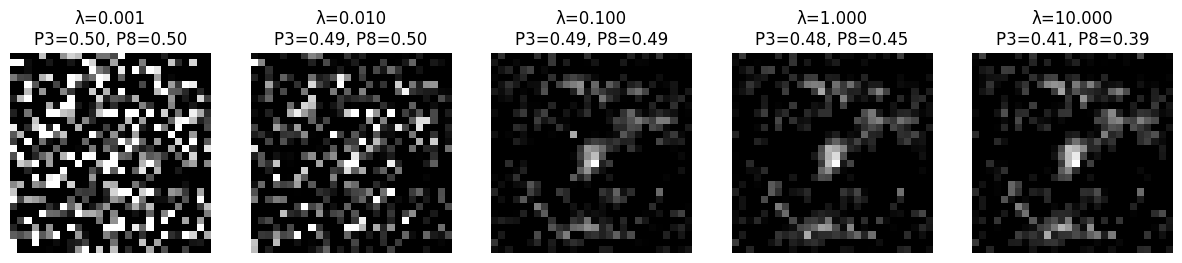

In [ ]:
#PROBLEM 3 (problem 2 with L2 penalty: constructing hybrid digit with L2 penalty)

import torch.nn.functional as F
import matplotlib.pyplot as plt

# defining clases for hybrid digit
target_classes = [3, 8]

# preparing set of lambdas
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]

# preparing for further vizualization
fig, axs = plt.subplots(1, len(lambda_values), figsize=(15, 3))

# random gaussian noise as input
base_input = torch.randn((1, 1, 28, 28), device=device)


for i, lambda_l2 in enumerate(lambda_values):

    # preparing input image
    hybrid_input = base_input.clone().detach().requires_grad_(True)

    # preparing optimizer
    optimizer = torch.optim.Adam([hybrid_input], lr=0.01)

    # optimization procedure (almost the same as in Problem 2)
    for step in range(3000):
        optimizer.zero_grad()
        logits = net(hybrid_input)
        probs = F.softmax(logits, dim=1)

        prob3 = probs[0, target_classes[0]]
        prob8 = probs[0, target_classes[1]]

        target_loss = (prob3 - 0.5) ** 2 + (prob8 - 0.5) ** 2

        # introducing L2 penalty to loss function
        l2_penalty = lambda_l2 * hybrid_input.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

    # preparing for vizualization
    img = hybrid_input.detach().cpu().clone()
    img = img.clamp(0, 1)

    # vizualization
    axs[i].imshow(img[0, 0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"λ={lambda_l2:.3f}\nP3={prob3.item():.2f}, P8={prob8.item():.2f}")


λ=0.001, Step 0, Loss: 4.9975, P(class): [0.001, 0.944, 0.006, 0.025, 0.001, 0.577, 0.001, 0.01, 0.0, 0.005]
λ=0.001, Step 500, Loss: 0.0014, P(class): [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.999]
λ=0.001, Step 1000, Loss: 0.0012, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 1500, Loss: 0.0011, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 2000, Loss: 0.0010, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 2500, Loss: 0.0010, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 2999, Loss: 0.0009, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.010, Step 0, Loss: 5.0067, P(class): [0.001, 0.944, 0.006, 0.025, 0.001, 0.577, 0.001, 0.01, 0.0, 0.005]
λ=0.010, Step 500, Loss: 0.0097, P(class): [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.999]
λ=0.010, Step 1000, Loss: 0.0087, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.010, Ste

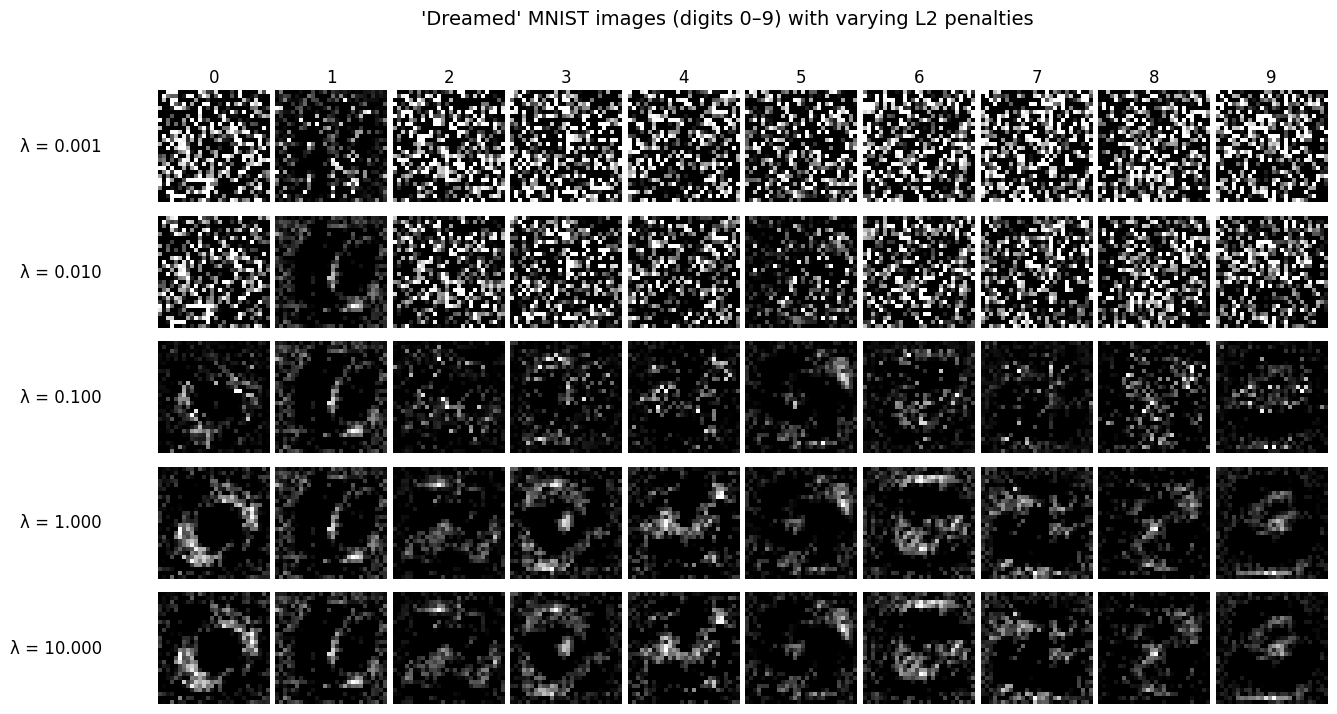

In [ ]:
### PROBLEM 3 (problem 1 with L2 penalty)

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


# generating 10 random gaussian noise iamges
base_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# setting target classes for images: i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# preparing set of lambda values
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]

# preparing for further vizualization
fig, axs = plt.subplots(len(lambda_values), 10, figsize=(15, 8))
if len(lambda_values) == 1:
    axs = axs.unsqueeze(0)

# "dreaming" procedure for every lambda
for i, lambda_l2 in enumerate(lambda_values):

    # getting input images
    dreamed_inputs = base_inputs.clone().detach().requires_grad_(True)

    # preparing optimizer
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    # optimizing procedure (almost the same as in Problem 1)
    for step in range(3000):
        optimizer.zero_grad()
        logits = net(dreamed_inputs)
        probs = F.softmax(logits, dim=1)
        target_loss = F.cross_entropy(logits, target_classes)

        # introducing L2 penalty to loss function
        l2_penalty = lambda_l2 * dreamed_inputs.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

        # displaying values of loss function and probabilities of "correct" classification
        if step % 500 == 0 or step == 2999:
            prob_class = probs.gather(1, target_classes.view(-1, 1))
            print(f"λ={lambda_l2:.3f}, Step {step}, Loss: {loss.item():.4f}, P(class): {[round(p.item(), 3) for p in prob_class]}")

    # Vizualization section
    images = dreamed_inputs.detach().cpu().clamp(0, 1)

    for j in range(10):
        ax = axs[i, j]
        ax.imshow(images[j, 0], cmap='gray')
        ax.axis('off')

        # labeling each row with lambda
        if j == 0:
            ax.annotate(f"λ = {lambda_l2:.3f}", xy=(0, 0.5), xycoords='axes fraction',
                        fontsize=12, ha='right', va='center', rotation=0,
                        xytext=(-40, 0), textcoords='offset points')
        if i ==0:
            ax.set_title(str(j), fontsize=12)

# Vizualization section 2
plt.suptitle("'Dreamed' MNIST images (digits 0–9) with varying L2 penalties", fontsize=14)
plt.subplots_adjust(top=0.88, left=0.12, wspace=0.05, hspace=0.1)
plt.show()


**Problem 3:**


Powyżej powtórzono zadania z Problemów 1 i 2 z dodaniem penalizacji szumu w obrazku. Przetestowano współczynniki penalizujące lambda należące do zbioru: [0.001, 0.01, 0.1, 1.0, 10.0].

Zmodyfikowany Problem 2:

Najpierw, warto zauważyć, iż algorytm dalej tworzy obrazki, które przypisuje jednocześnie do dwóch klas - "3" i "8", jednak z powodu wprowadzenia kary, dla większych $\lambda$, z mniejszą pewnością stwierdza, że obrazek należy do klas "3" i "8". Jak możemy zobaczyć w *outpucie* dla $\lambda =10$ prawdopodobieństwa przynależności do tych dwóch klas wynoszą około 0.4, a nie 0.5 jak wcześniej. Jednak, dla mniejszych $\lambda$ niż 10 wartości prawdopodobieństw są już zbliżone do 0.5.

Na podstawie wygenerowanych obrazków, można stwierdzić, że wprowadzenie kary poprawia widoczność liczb, jednak trzeba dobrać odpowiednią wartość $\lambda$, gdyż zbyt małe wartości niewystarczająco wpływają na obraz, a zbyt duże aż nazbyt go upraszczają. W naszym eksperymencie, możemy zauważyć, że dla parametru 0.001 obraz dalej zawiera zbyt dużo szumu, a dla parametru 10 jest już mocno uprosczony. Wydaje się, iż najlepiej wygląda obraz dla $\lambda =1$, gdyż nie występuje tam dużo szumu, a widać zarysy cyfr "3" i "8" (oczywiście nie są one idealne, ale występuje znaczna poprawa względem przypdaku bez penalizacji).

Poniżej zamieszam obrazki z moją interpretacją zarysów cyfr "3" i "8" dla $\lambda=1$:

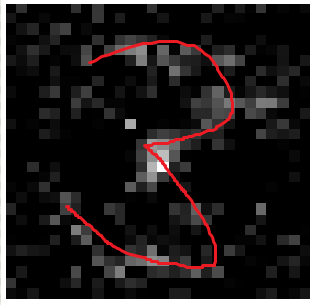



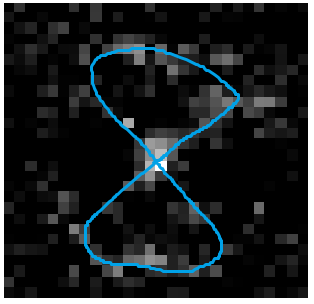


Zmodyfikowany Problem 1:

Tutaj wnisoki są podobne jak dla Zmodyfikowanego Problemu 2. Algorytm, po prowadzeniu penalizacji, również dobrze radzi sobie z generowaniem obrazków dla porządanych cyfr. W *outpucie* możemy zauważyć, że pod koniec procesu optymalizacji wszytskie wartości *confidence* (czyli prawdopodobieństwa, że dany obrazek jest dobrze sklasyfikowany według sieci) są bardzo bliskie 1.

Znowu, można powiedzieć, że wporwadzenie kary znacznie polepsza jakość generowanych cyfr, jednak w dużej mierze zależy to od warości parametru $\lambda$. Zbyt małe wartości nieznacznie penalizują szum, przez co obraz jest dalej nieczytleny, a zbyt duże upraszczają go w zbytnim stopniu.

Na podstawie analizy *outputu*, powiedziałbym, iż najczytelniejsze obrazki generuje wersja algorytmu z parametrem 1, jednak na uznanie zasługują też wersje z parametrem 0.1 (ta według mnie ma trochę za duży szum) i 10 (ta gubi trochę więcej elementów cyfr niż wersja z parametrem 1).

Warto zaznaczyć, iż nawet wersja z parametrem 1 nie odwzorywuje cyfr w bardzo czytelny sposób, jednak dla większości obrazków da się stwierdzić jaka to cyfra.

Obserwacja "wyśnionych" obrazków w algorytmie z penalizacją daje całkiem dobry wgląd w to, jakie elementy są ważne dla sieci podczas generowania danej cyfry. Przez fakt, że w procesie optymalizacji penalizowany jest szum, algorytm zostawia elementy, które są dla niego relatywnie ważniejsze w rozpoznawaniu konkretnej cyfry. Na przykład, dla cyfry "9" możemy zobaczyć, iż sieć raczej skupia się na górnej pętli i dolnej stopce cyfry "9", a nie na łączniku pomiędzy pętlą, a stopką (poniżej obrazek cyfry "9" dla parametrów 1 i 10):


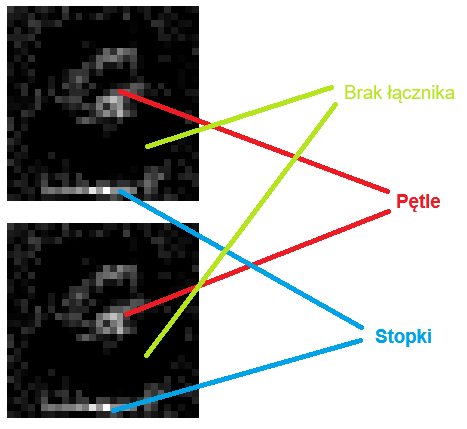

